### Clustering the processed spectrograms

We have now filtered out the up-and-down shifts. Next, we categorize anomalies into groups/classes using a deep/unsupervised learning/ hybrid approach.  
To do this, we take a clustering approach that leverages a Deep Neural Network (DNN), kMeans clustering, and result tuning using object detection.  

- Applied a ResNet model to each image to compute a feature vector
- Filtered for non-event data 
- Trained a clusterer and extracted labels for each image
- 5 total clusters found: 
    - Seemingly long/wide bands, long/tall bands, sparse short bursts, and multiple short bursts 


In [51]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from os import listdir
import matplotlib.image as mpimg
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
import glob
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')

#### Leveraging the ResNet50 model (CNN) 

In [5]:
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

my_new_model = Sequential()
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

In [6]:
IMG_SHAPE = (90, 322, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False,weights='imagenet')

In [7]:
#returns the array list feature vectors and a list of indecies for all black images
def extract_vector(path, n_samples):
    zero_list = []
    non_zero_list = []
    resnet_feature_list = []
    image_list = listdir("editSpectograms")
    
    image_list = [x for x in image_list if '.jpg' in x]
    for i, im in enumerate(image_list[:n_samples]):
        im = cv2.imread("editSpectograms/" + im)
        if np.sum(im) == 0:
            zero_list.append(i)
        else: non_zero_list.append(i)
        im = cv2.resize(im,(224,224))
        img = preprocess_input(np.expand_dims(im.copy(), axis=0))
        resnet_feature = my_new_model.predict(img)
        resnet_feature_np = np.array(resnet_feature)
        resnet_feature_list.append(resnet_feature_np.flatten())
        
    return (np.array(resnet_feature_list), zero_list, non_zero_list)

In [9]:
# get the image names
image_list = listdir("editSpectograms")
image_list = [x for x in image_list if '.jpg' in x]
num_images = 3600

In [ ]:
feature_list, zero_list, non_zero_list = extract_vector("editSpectograms", num_images)

In [ ]:
## saving information
# np.save("features", feature_list)
# np.save("zero_list", np.asarray(zero_list))
# np.save("non_zero_list", np.asarray(non_zero_list))

In [37]:
### use this if already saved
non_zero_list = np.load('./non_zero_list.npy')
zero_list = np.load('./zero_list.npy')
feature_list = np.load('./features.npy')

In [38]:
feature_list_non_z = feature_list[non_zero_list]

#### Clustering with kMeans -- filter non-events and tune derived classes
(Note: we tried DBSCAN but did not get better results)

In [39]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(feature_list_non_z)

In [40]:
# we only classified the non-all black images. But still -- these belong in their own class
# Turn all black into class 0. All others belong to class n + 1
final_class_list = []
j = 0
for i in range(feature_list.shape[0]):
    if i in non_zero_list:
        final_class_list.append(kmeans.labels_[j] + 1)
        j += 1
    else:
        final_class_list.append(0) #class zero represents an all black image

In [41]:
def show_kmeans_img(label_num): #just display the first 20
    k = 0
    for i in range(len(final_class_list)):
        if final_class_list[i] == label_num:
            im = cv2.imread("editSpectograms/" + image_list[i])
            print(image_list[i])
            plt.imshow(im)
            plt.show()
            k += 1
        if k > 50: break

We noticed that one of the classes contained "long" segments. These were both vertical and horizontal, and should be seperated  
Seperation is determined by the ratio or width to height of a bounding box derived via object detection

In [42]:
#Converts the pixel values in our slice to frequencies based on the scale
def intToFrequency(number, bottom_frequency, top_frequency, max_value):
    difference = top_frequency - bottom_frequency
    percentage = number / max_value
    return round(top_frequency - percentage * difference - 2, 2)

In [43]:
## make new class 1. 
new_class = np.max(final_class_list) + 1
for i, img_index in enumerate(final_class_list):
    if img_index == 1:
        
        file = image_list[i]
        filename = "./editSpectograms/" + file
        im = cv2.imread(filename)
        RGB_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        res = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   
        res = cv2.blur(res,(6,3))
        #Creates canny edges
        display = cv2.Canny(res, 90, 300)
        mask = cv2.inRange(display, 100, 255)
        kernel = np.ones((5, 5), np.uint8)
        # Erode / dilate to make label appear "boxy"
        boxy = cv2.erode(mask, kernel, iterations=0)
        boxy = cv2.dilate(boxy, kernel, iterations=1)

        ##Create the boxes
        contours, _ = cv2.findContours(boxy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        width_list = []
        frequency_list = []
        
        max_area = 0; max_idx = 0
        max_area_width = 0; max_area_height = 0; max_height = 0
        k = 0
        
        for contour in contours:
            cv2.drawContours(im, contour, -1, (0, 255, 0), 3)
            boundRect = cv2.boundingRect(contour)
            color = (180, 180, 180)
            cv2.rectangle(boxy, (int(boundRect[0]), int(boundRect[1])), 
            (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), color, 2)
            cv2.rectangle(RGB_img, (int(boundRect[0]), int(boundRect[1])), 
            (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), color, 2)

            width = boundRect[2]
            height= boundRect[3]
            
            if ((width*height) > max_area):
                max_area = width*height
                max_idx = i
                max_area_width = width
                max_area_height = height
            k += 1

        if max_area_height > .9 *max_area_width: 
            final_class_list[i] = new_class


In [44]:
cluster_dict = {}
for i in range(len(final_class_list)):
    cluster_dict.update({image_list[i]:final_class_list[i]})

e_5_08_15_00.jpg


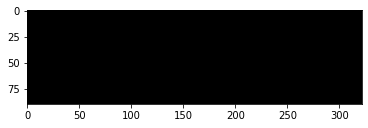

e_1_22_45_00.jpg


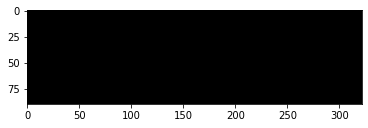

e_4_19_55_00.jpg


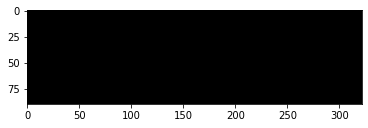

e_3_11_47_30.jpg


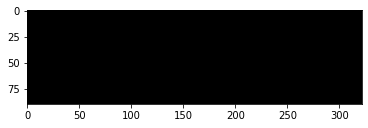

e_1_14_47_30.jpg


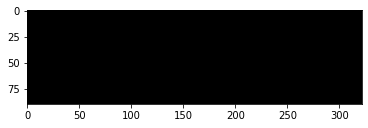

e_4_11_50_00.jpg


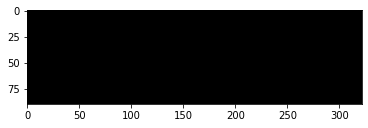

e_5_04_32_30.jpg


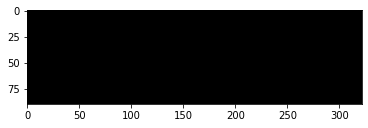

e_6_14_50_00.jpg


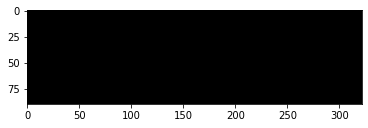

e_2_08_02_30.jpg


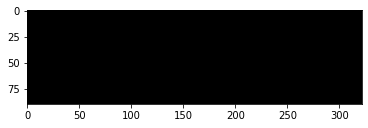

e_5_17_50_00.jpg


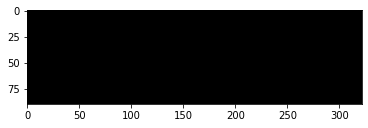

e_6_07_32_30.jpg


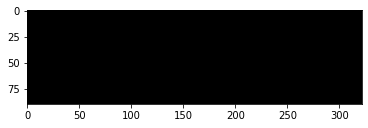

e_6_03_10_00.jpg


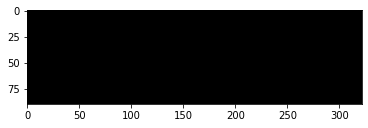

e_4_06_10_00.jpg


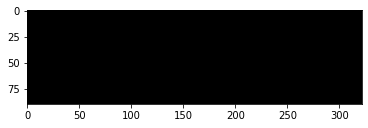

e_4_02_32_30.jpg


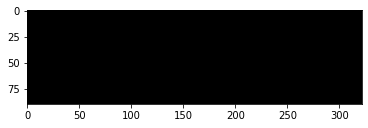

e_1_07_25_00.jpg


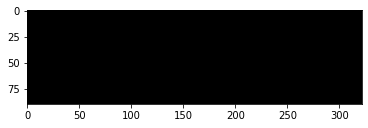

e_1_03_07_30.jpg


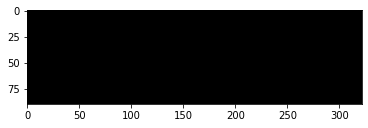

e_3_06_07_30.jpg


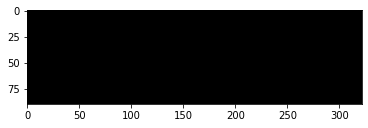

e_3_02_25_00.jpg


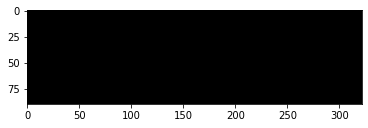

e_2_08_15_00.jpg


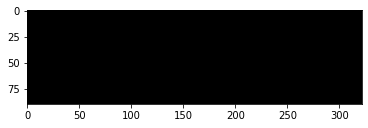

e_5_04_25_00.jpg


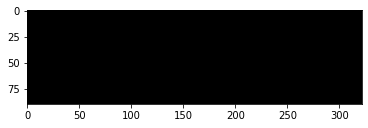

e_5_00_07_30.jpg


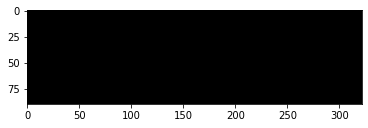

e_6_14_47_30.jpg


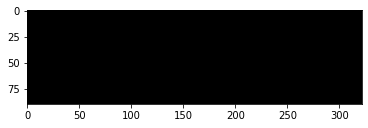

e_4_11_47_30.jpg


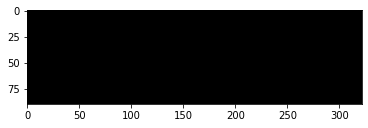

e_1_14_50_00.jpg


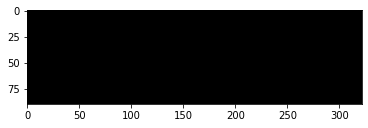

e_3_11_50_00.jpg


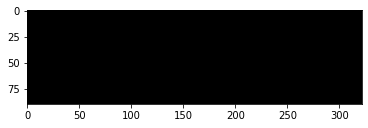

e_5_08_02_30.jpg


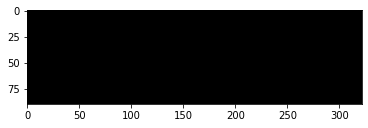

e_1_22_52_30.jpg


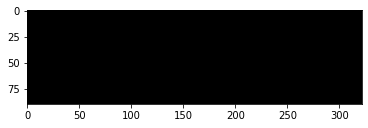

e_3_06_10_00.jpg


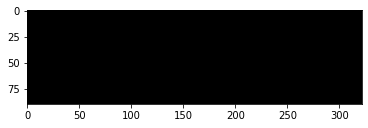

e_1_07_32_30.jpg


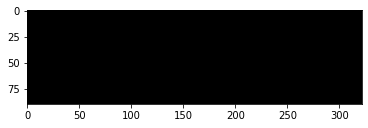

e_4_06_07_30.jpg


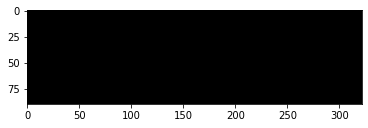

e_6_03_07_30.jpg


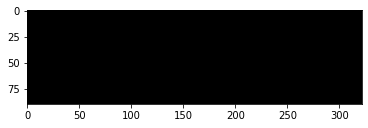

e_5_21_45_00.jpg


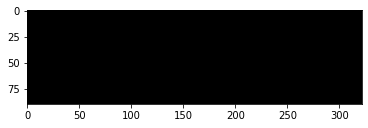

e_4_20_27_30.jpg


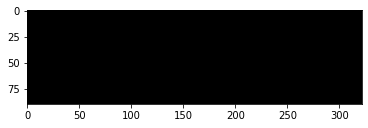

e_6_13_25_00.jpg


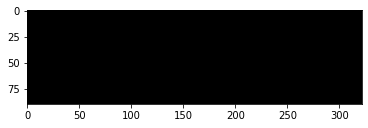

e_4_16_25_00.jpg


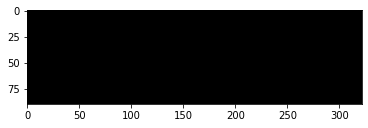

e_4_12_07_30.jpg


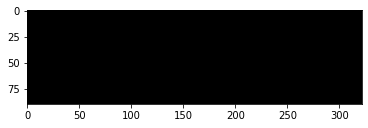

e_2_03_50_00.jpg


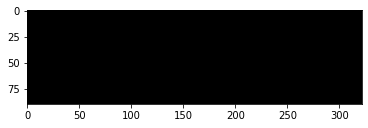

e_1_17_10_00.jpg


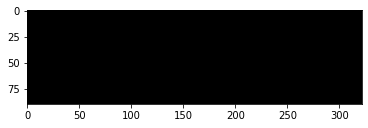

e_1_13_32_30.jpg


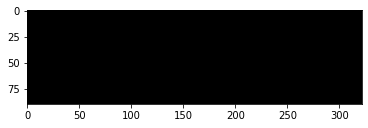

e_3_16_32_30.jpg


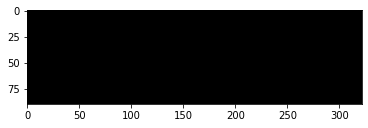

e_5_18_20_00.jpg


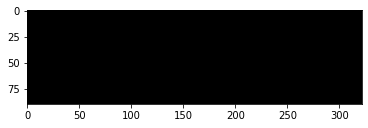

e_6_08_42_30.jpg


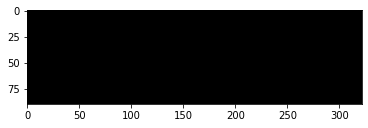

e_3_05_50_00.jpg


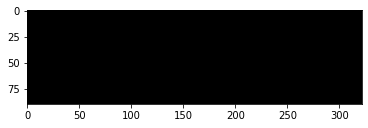

e_2_10_32_30.jpg


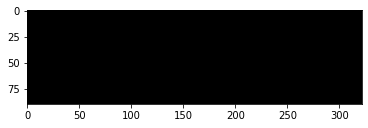

e_1_00_50_00.jpg


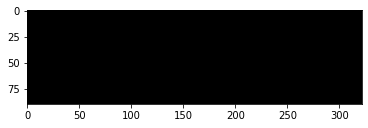

e_4_05_47_30.jpg


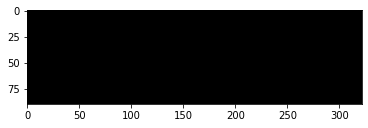

e_5_14_07_30.jpg


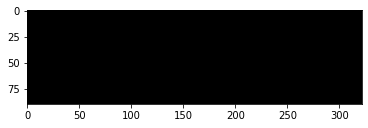

e_5_10_25_00.jpg


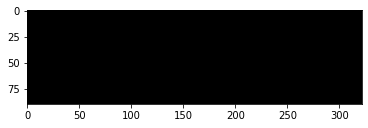

e_2_18_37_30.jpg


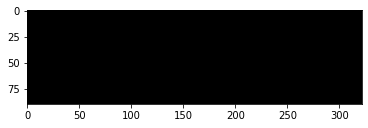

e_1_08_55_00.jpg


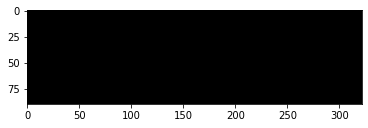

e_1_21_05_00.jpg


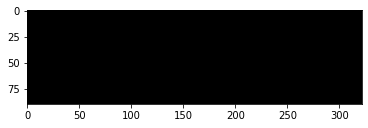

In [54]:
show_kmeans_img(0)

e_1_02_20_00_sig.jpg


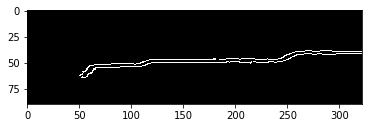

e_2_04_32_30.jpg


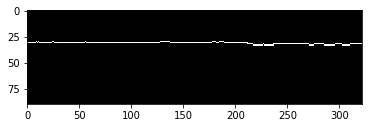

e_3_02_32_30.jpg


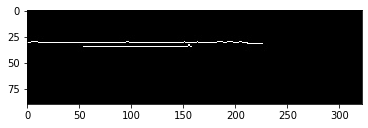

e_6_21_05_00.jpg


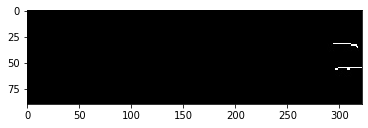

e_4_01_32_30_sig.jpg


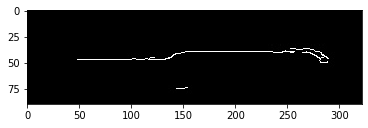

e_1_17_07_30.jpg


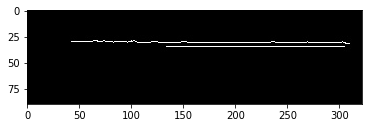

e_5_03_50_00.jpg


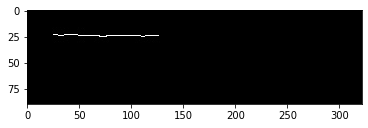

e_5_18_37_30.jpg


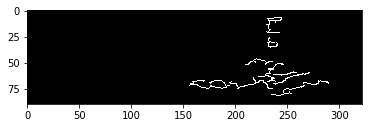

e_2_22_47_30.jpg


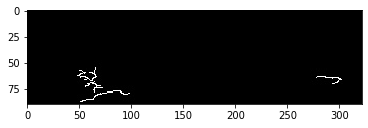

e_3_05_05_00.jpg


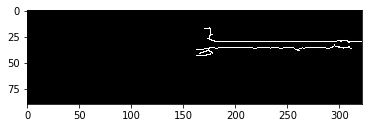

e_4_01_30_00.jpg


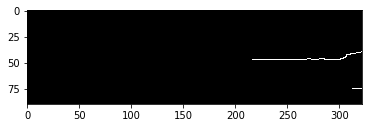

e_3_17_15_00_sig.jpg


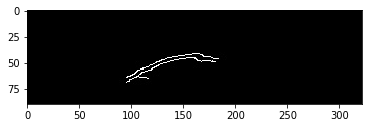

e_1_22_07_30.jpg


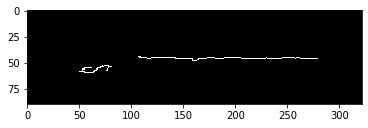

e_5_21_07_30.jpg


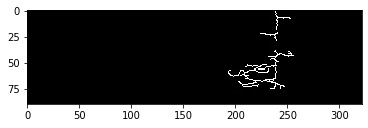

e_4_23_25_00.jpg


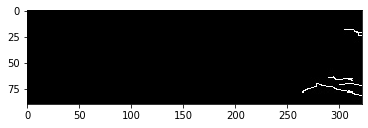

e_4_14_55_00.jpg


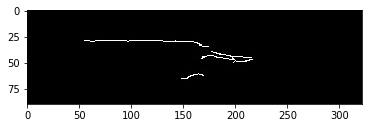

e_6_19_47_30.jpg


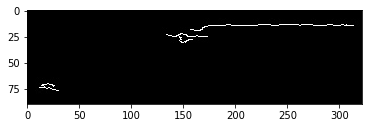

e_4_08_47_30.jpg


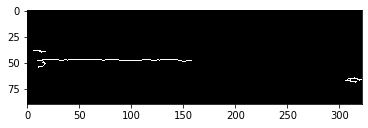

e_4_17_02_30.jpg


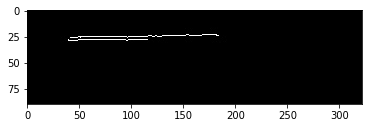

e_3_01_30_00_sig.jpg


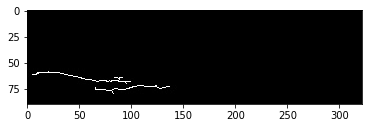

e_3_21_17_30.jpg


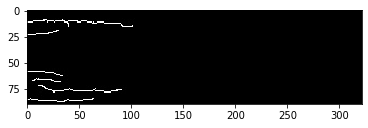

e_4_08_50_00.jpg


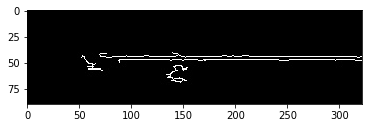

e_4_08_12_30.jpg


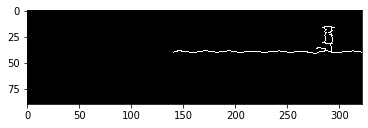

e_1_14_05_00_sig.jpg


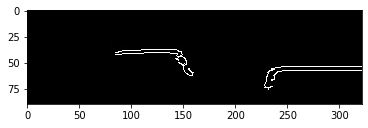

e_4_18_27_30.jpg


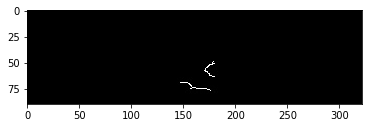

e_3_17_12_30.jpg


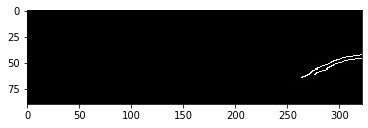

e_4_08_57_30.jpg


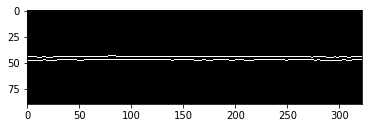

e_5_19_17_30.jpg


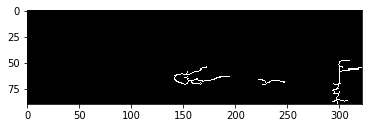

e_3_17_50_00.jpg


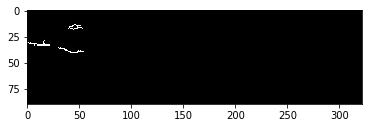

e_4_00_07_30.jpg


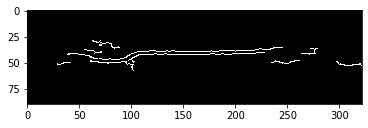

e_3_01_12_30_sig.jpg


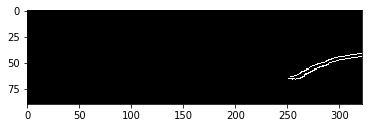

e_1_23_27_30.jpg


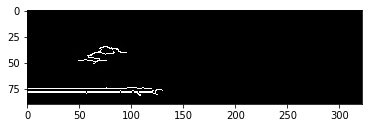

e_5_20_30_00.jpg


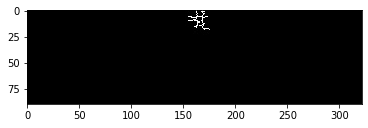

e_4_11_57_30.jpg


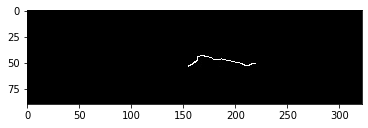

e_3_11_57_30.jpg


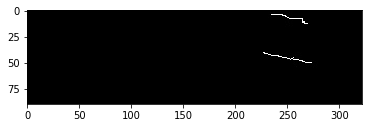

e_3_19_20_00_sig.jpg


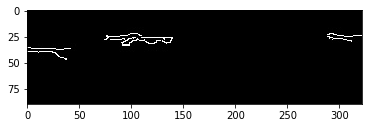

e_3_17_37_30_sig.jpg


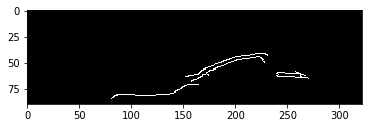

e_4_12_00_00.jpg


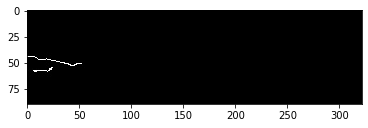

e_1_02_25_00_sig.jpg


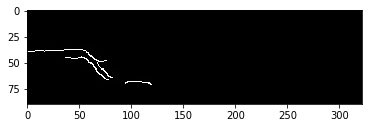

e_6_21_15_00.jpg


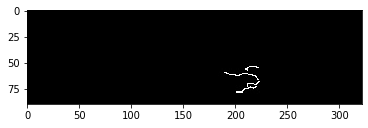

e_2_03_07_30_sig.jpg


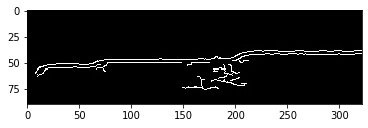

e_1_18_37_30_sig.jpg


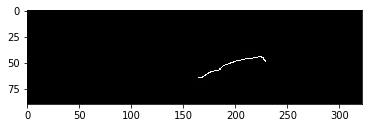

e_3_01_37_30.jpg


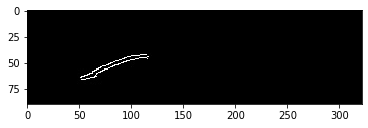

e_3_19_07_30.jpg


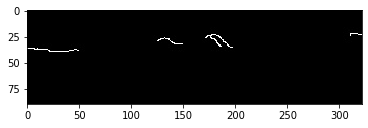

e_6_10_37_30.jpg


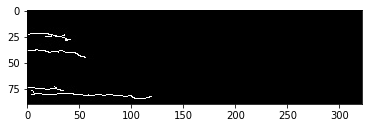

e_6_14_02_30.jpg


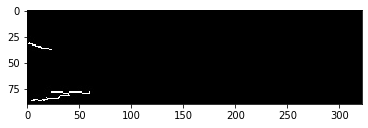

e_2_03_10_00_sig.jpg


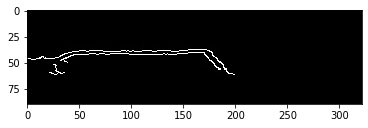

e_3_13_07_30.jpg


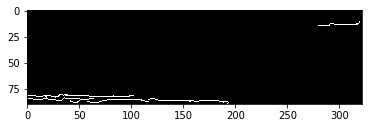

e_2_19_20_00.jpg


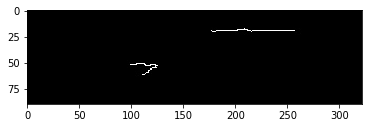

e_4_22_25_00.jpg


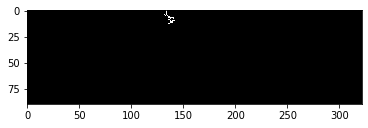

e_4_08_35_00.jpg


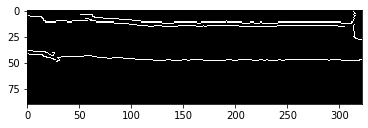

In [47]:
# show_kmeans_img(1)

e_6_07_25_00.jpg


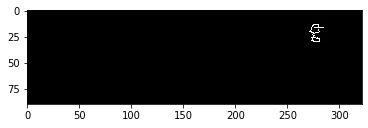

e_5_22_12_30.jpg


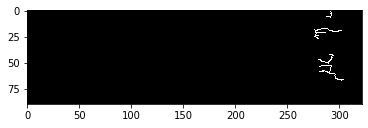

e_6_00_12_30.jpg


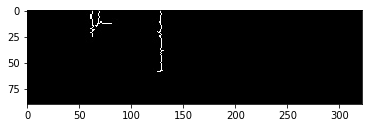

e_6_17_52_30.jpg


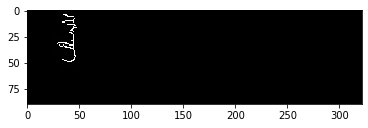

e_5_23_35_00.jpg


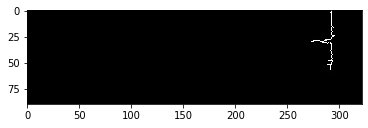

e_4_21_10_00.jpg


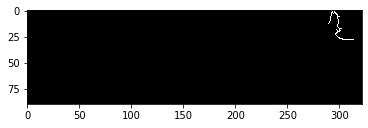

e_2_19_55_00.jpg


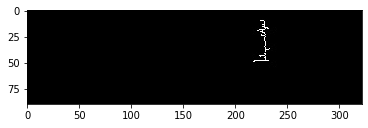

e_5_22_15_00.jpg


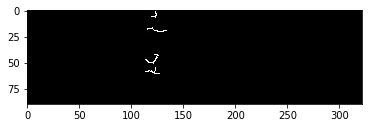

e_5_21_17_30.jpg


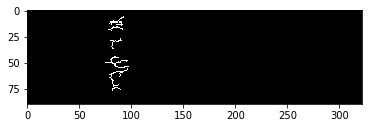

e_6_15_47_30.jpg


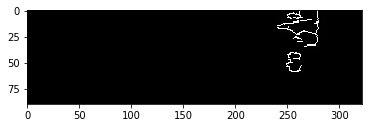

e_2_16_12_30.jpg


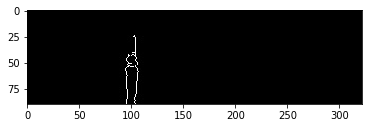

e_5_23_50_00.jpg


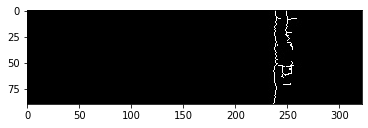

e_3_20_17_30.jpg


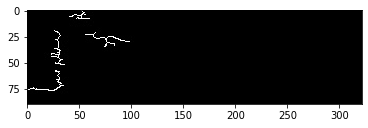

e_5_04_15_00.jpg


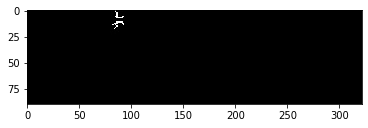

e_4_23_15_00.jpg


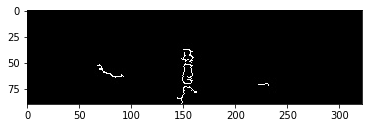

e_6_04_45_00.jpg


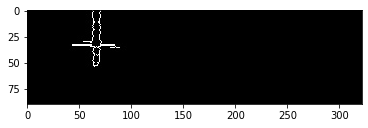

e_4_20_10_00.jpg


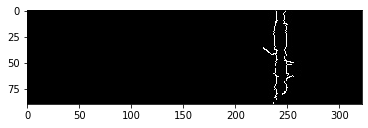

e_4_06_27_30.jpg


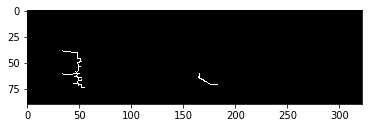

e_4_23_12_30.jpg


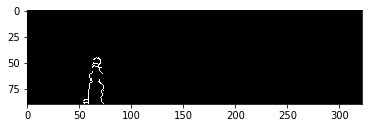

e_1_13_47_30.jpg


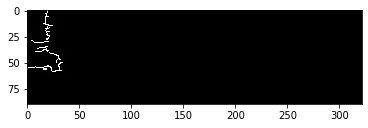

e_5_07_10_00.jpg


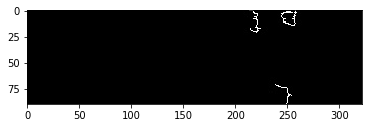

e_6_01_57_30.jpg


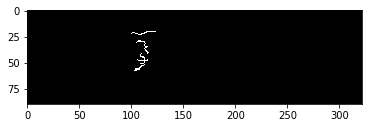

e_4_07_55_00.jpg


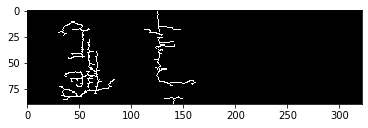

e_5_23_52_30.jpg


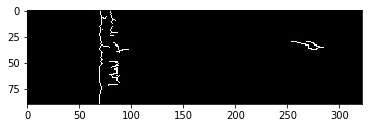

e_6_20_45_00.jpg


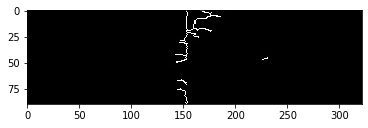

e_2_16_10_00.jpg


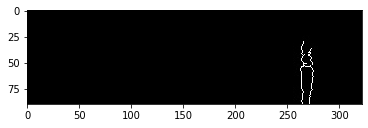

e_4_06_35_00.jpg


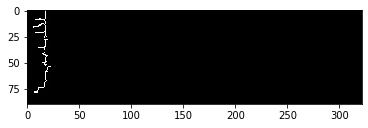

e_1_21_20_00.jpg


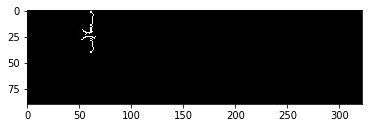

e_4_06_32_30.jpg


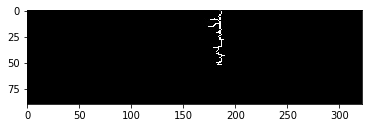

e_5_04_10_00.jpg


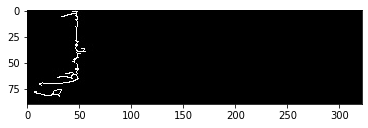

e_4_20_12_30.jpg


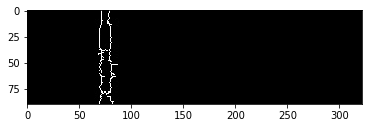

e_4_23_10_00.jpg


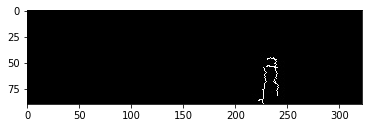

e_2_03_12_30_sig.jpg


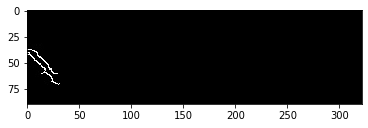

e_6_20_55_00.jpg


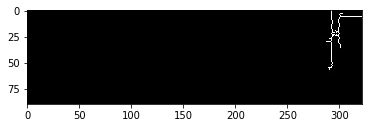

e_6_07_27_30.jpg


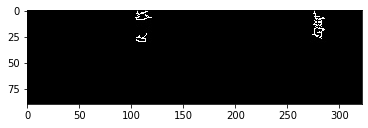

e_6_07_30_00.jpg


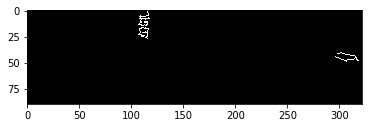

e_5_17_10_00.jpg


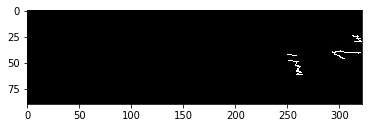

e_2_22_45_00.jpg


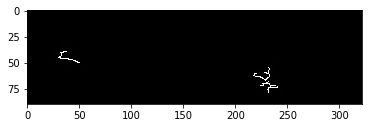

e_5_23_37_30.jpg


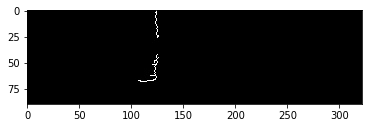

e_4_08_10_00.jpg


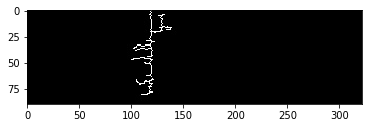

e_4_00_15_00.jpg


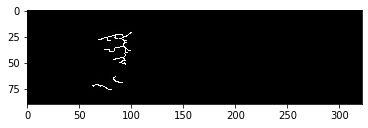

e_4_17_42_30.jpg


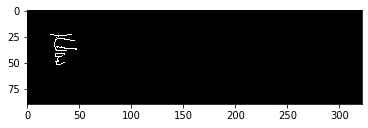

e_4_08_07_30.jpg


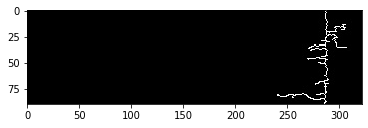

e_5_15_32_30.jpg


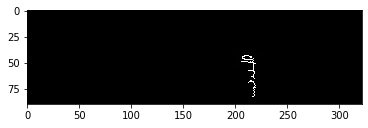

e_4_21_12_30.jpg


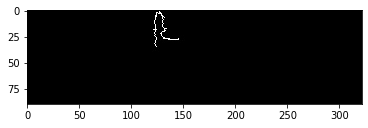

e_3_22_45_00.jpg


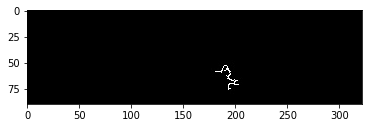

e_4_00_12_30.jpg


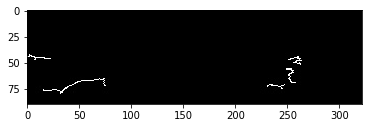

e_5_21_15_00.jpg


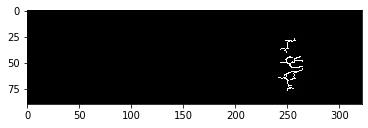

In [48]:
# show_kmeans_img(new_class)

e_2_00_07_30.jpg


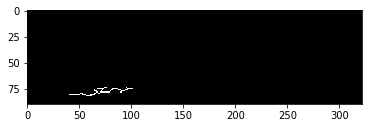

e_5_00_10_00.jpg


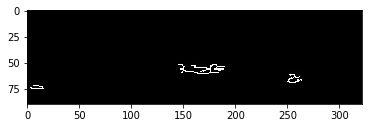

e_6_22_52_30.jpg


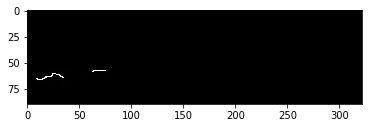

e_3_19_42_30.jpg


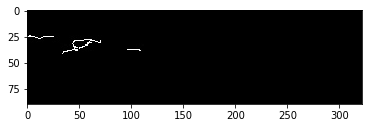

e_6_22_45_00.jpg


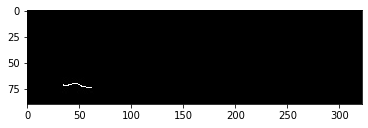

e_2_17_50_00.jpg


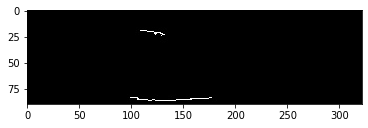

e_4_02_25_00.jpg


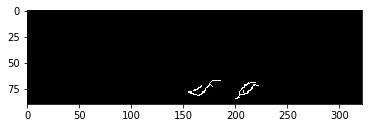

e_5_17_47_30.jpg


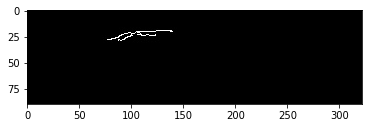

e_5_03_47_30.jpg


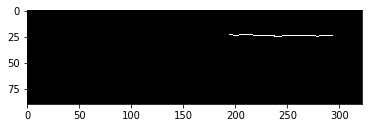

e_6_17_07_30.jpg


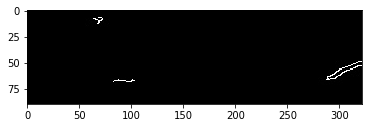

e_3_12_10_00.jpg


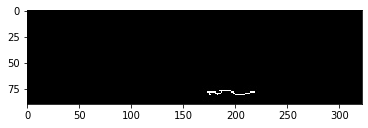

e_3_20_30_00.jpg


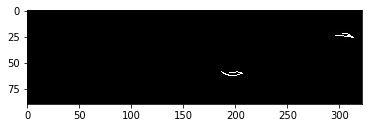

e_1_21_12_30.jpg


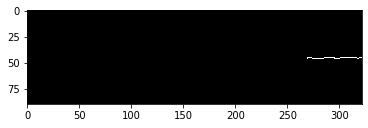

e_2_14_10_00.jpg


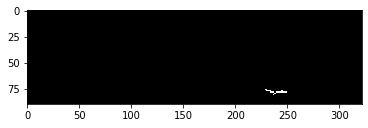

e_6_00_47_30.jpg


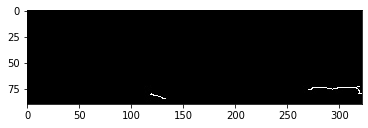

e_5_22_05_00.jpg


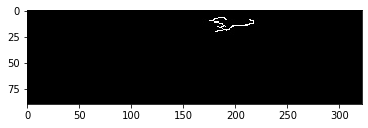

e_3_20_27_30.jpg


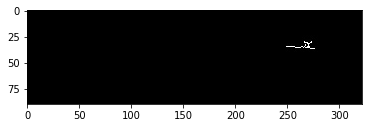

e_3_16_25_00.jpg


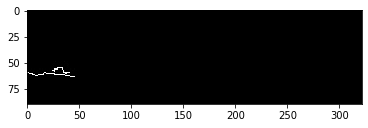

e_4_16_32_30.jpg


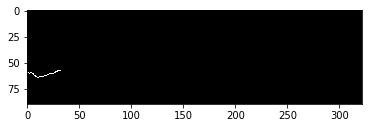

e_6_13_32_30.jpg


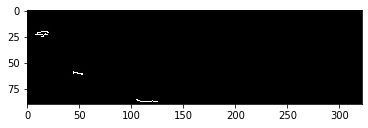

e_6_21_12_30.jpg


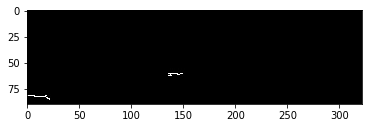

e_2_18_20_00.jpg


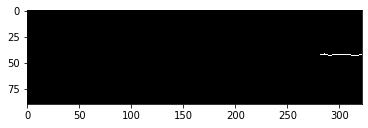

e_1_00_47_30.jpg


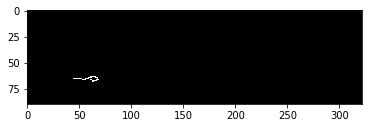

e_2_22_05_00.jpg


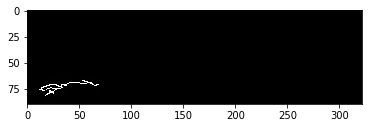

e_2_22_50_00.jpg


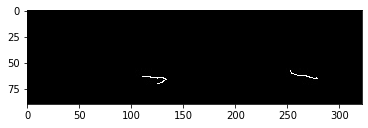

e_1_21_50_00.jpg


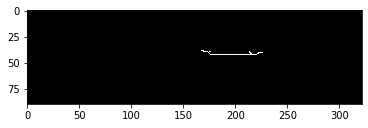

e_3_12_52_30.jpg


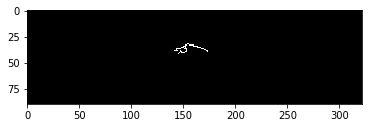

e_3_04_32_30_sig.jpg


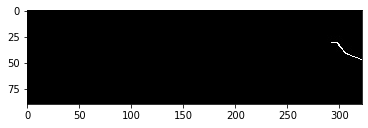

e_6_21_47_30.jpg


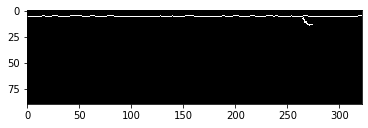

e_6_21_50_00.jpg


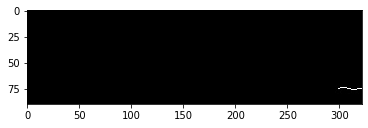

e_5_03_12_30.jpg


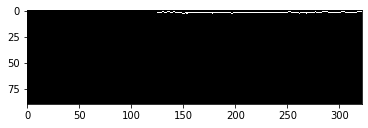

e_1_17_45_00.jpg


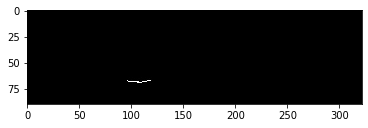

e_3_19_00_00.jpg


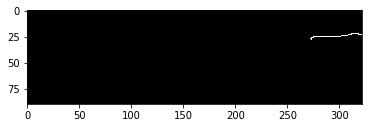

e_4_23_32_30.jpg


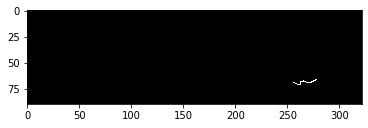

e_6_22_10_00.jpg


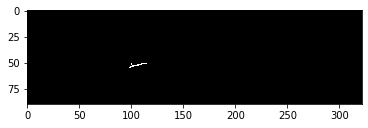

e_6_14_12_30.jpg


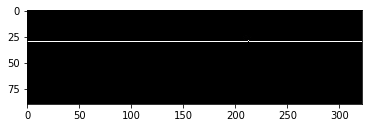

e_2_00_45_00.jpg


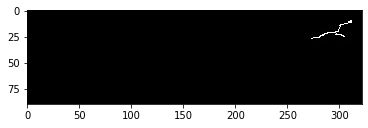

e_4_06_45_00.jpg


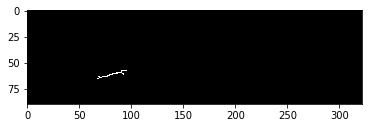

e_2_17_12_30.jpg


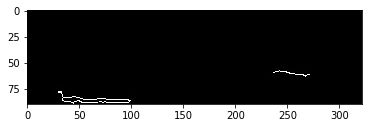

e_3_06_52_30.jpg


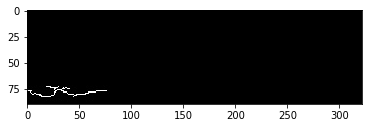

e_1_22_10_00.jpg


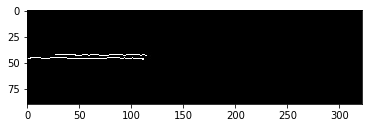

e_4_15_27_30.jpg


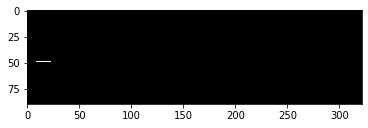

e_4_11_05_00.jpg


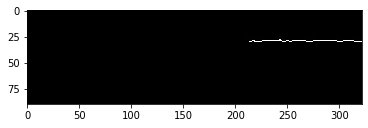

e_5_00_45_00.jpg


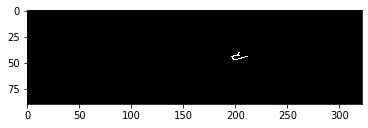

e_6_22_07_30.jpg


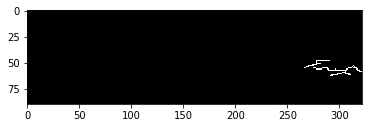

e_2_12_42_30.jpg


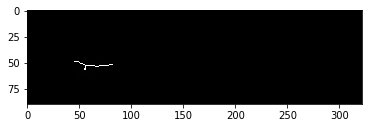

e_3_07_20_00.jpg


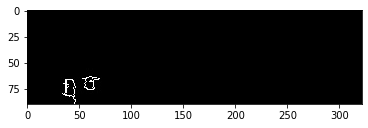

e_3_14_42_30.jpg


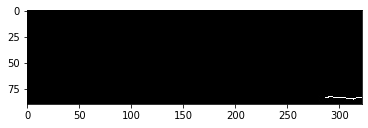

e_1_11_42_30.jpg


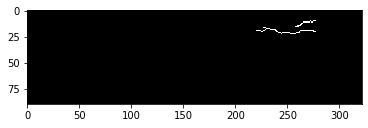

e_1_20_30_00_sig.jpg


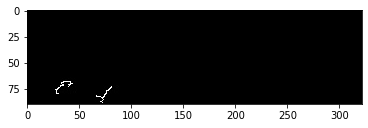

e_5_05_15_00.jpg


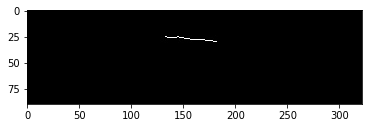

In [49]:
# show_kmeans_img(2)

e_2_04_25_00.jpg


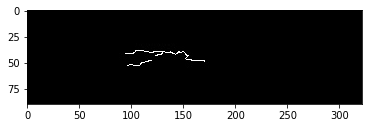

e_5_21_52_30.jpg


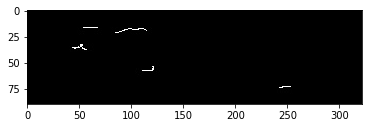

e_2_17_47_30.jpg


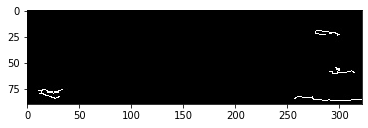

e_2_21_45_00.jpg


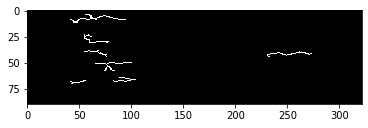

e_2_00_10_00.jpg


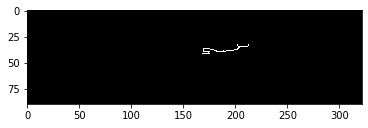

e_4_19_42_30.jpg


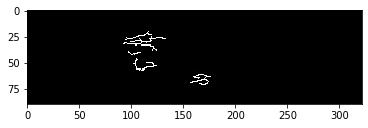

e_3_20_25_00_sig.jpg


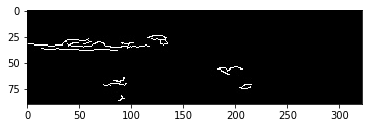

e_2_21_52_30.jpg


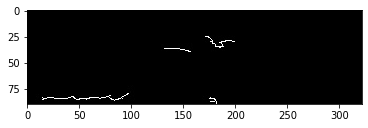

e_1_03_10_00.jpg


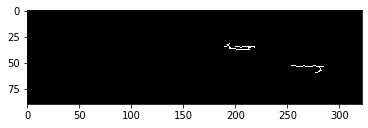

e_2_22_12_30.jpg


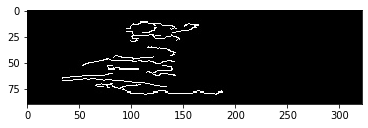

e_6_00_50_00.jpg


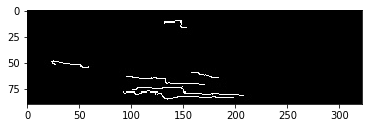

e_4_01_27_30.jpg


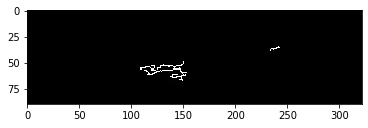

e_1_00_12_30.jpg


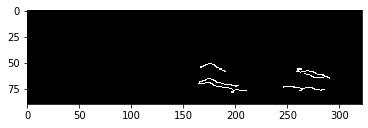

e_2_14_52_30.jpg


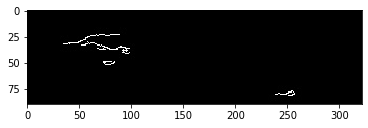

e_5_05_07_30_sig.jpg


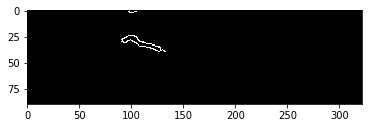

e_5_17_12_30.jpg


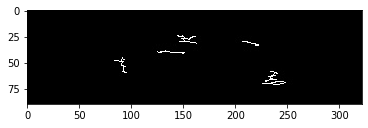

e_5_21_10_00.jpg


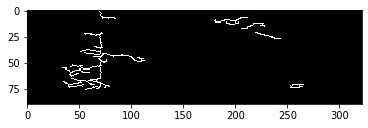

e_3_23_25_00.jpg


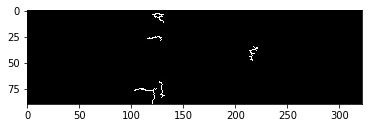

e_3_23_32_30.jpg


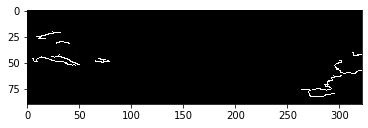

e_4_19_00_00.jpg


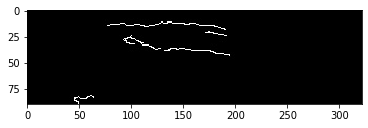

e_2_00_52_30.jpg


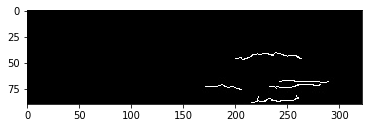

e_6_02_37_30.jpg


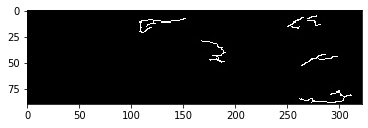

e_3_18_27_30_sig.jpg


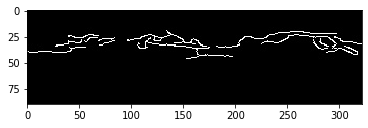

e_1_19_47_30.jpg


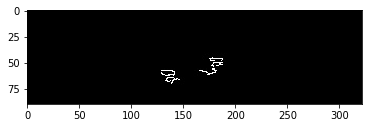

e_3_00_55_00.jpg


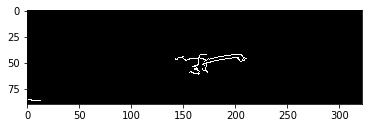

e_2_15_37_30.jpg


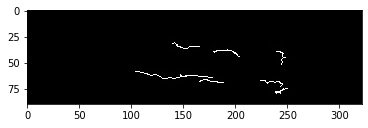

e_5_19_07_30.jpg


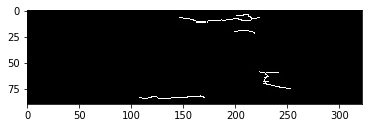

e_1_20_35_00.jpg


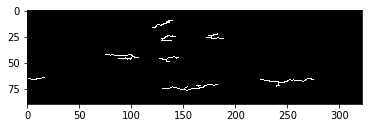

e_2_23_22_30.jpg


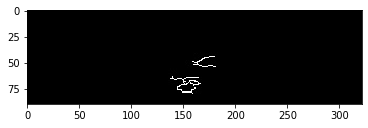

e_1_16_20_00.jpg


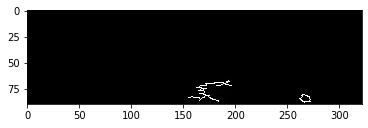

e_4_21_17_30.jpg


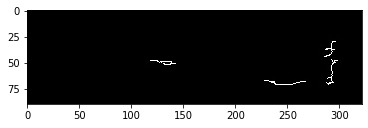

e_4_13_37_30.jpg


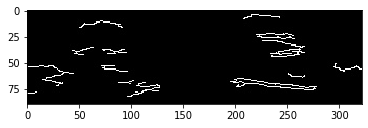

e_6_16_37_30.jpg


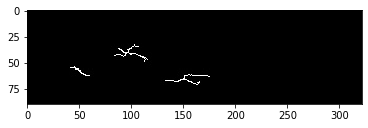

e_2_02_35_00.jpg


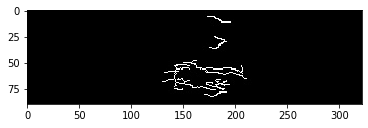

e_4_21_42_30.jpg


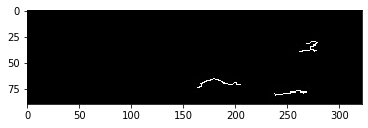

e_4_17_40_00.jpg


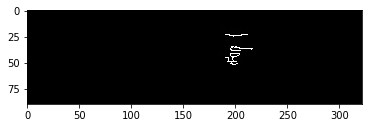

e_5_19_45_00.jpg


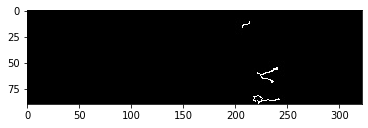

e_2_11_57_30.jpg


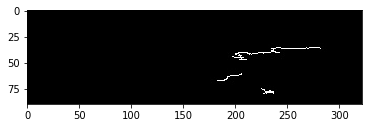

e_3_00_17_30.jpg


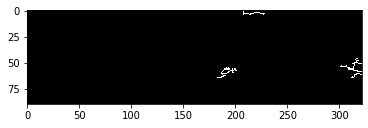

e_4_21_55_00.jpg


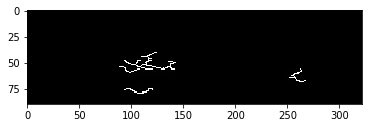

e_2_02_22_30.jpg


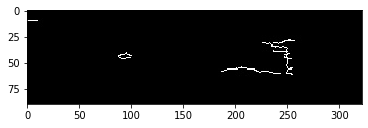

e_3_17_40_00.jpg


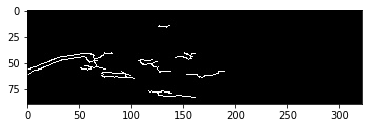

e_2_19_45_00.jpg


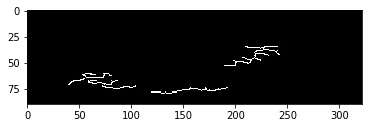

e_5_05_57_30.jpg


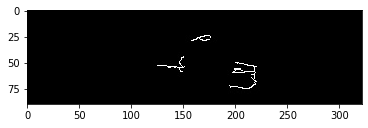

e_1_19_05_00.jpg


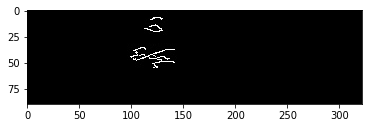

e_5_04_50_00_sig.jpg


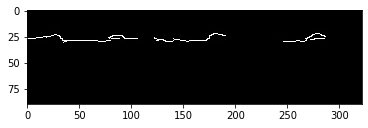

e_2_12_00_00.jpg


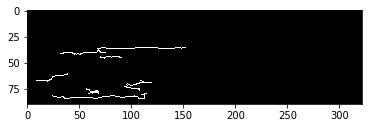

e_4_22_02_30.jpg


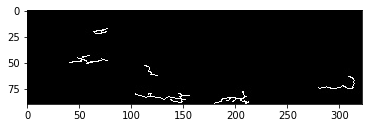

e_2_16_35_00.jpg


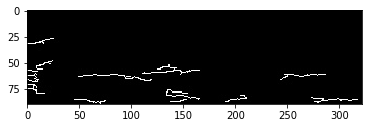

e_2_12_45_00.jpg


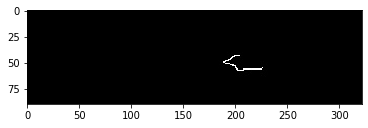

e_3_14_45_00.jpg


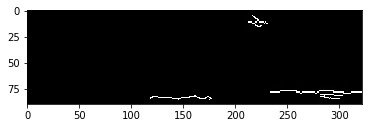

In [50]:
# show_kmeans_img(3)